In [2]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# x''(t) = -(alpha/m)*(x')**2 - (alpha/m)*wind**2
def dU_dt(t, U, alphax, m, windx_dir, windx):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], -(alphax/m)*(U[1]**2-windx_dir*windx**2)]

# y''(t) = -(alpha/m)*(y')**2 - (alpha/m)*wind**2 - g
def dV_dt(t, V, alphay, m, windy_dir, windy, g):
    return [V[1], (alphay/m)*(V[1]**2+windy_dir*windy**2)-g]

In [62]:
Cx = 1.2 # https://fr.wikipedia.org/wiki/Coefficient_de_tra%C3%AEn%C3%A9e
rho = 1.225 # https://fr.wikipedia.org/wiki/Masse_volumique_de_l%27air
Sx = 0.4*1.8
Sy = 0.15*0.15
alphax = (1/2)*Cx*rho*Sx
alphay = (1/2)*Cx*rho*Sy

windx_dir = 1 # or -1, wind oriented in the same direction as the x vector (push the human if positive)
windy_dir = 1 # or -1, wind oriented in the same direction as the y vector (slow the fall of the human if positive)
windx = 0 # Speed in m/s of wind in x axis
windy = 0 # Speed in m/s of wind in y axis

m = 70
g = 9.8

t0 = 0
tend = 2

x0 = 0
vx0 = 5

y0 = 10
vy0 = 0

U0 = [x0, vx0]
V0 = [y0, vy0]
ts = np.linspace(t0, tend, 200)

In [63]:
Us = scipy.integrate.solve_ivp(dU_dt, t_span=(t0, tend), y0=(x0, vx0), method="RK45", args=(alphax, m, windx_dir, windx), dense_output=True)
xs = Us.sol(ts)[0]

In [67]:
Vs = scipy.integrate.solve_ivp(dV_dt, t_span=(t0, tend), y0=(y0, vy0), method="RK45", args=(alphay, m, windy_dir, windy, g), dense_output=True)
ys = Vs.sol(ts)[0]

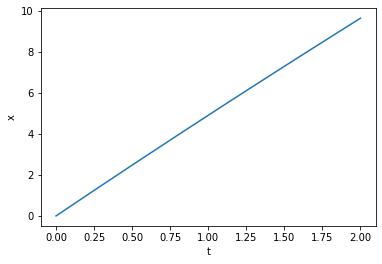

In [68]:
plt.xlabel("t")
plt.ylabel("x")
plt.plot(ts,xs)
# plt.xlim([0, 3])
# plt.ylim([-5, 15])
plt.show()

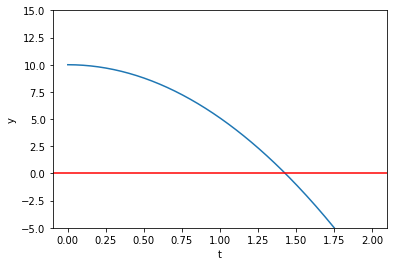

In [69]:
plt.xlabel("t")
plt.ylabel("y")
# plt.xlim([0, 3])
plt.ylim([-5, 15])
plt.plot(ts,ys)
plt.axhline(y=0, color='r')
plt.show()

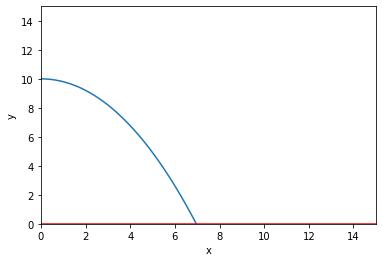

In [70]:
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.plot(xs, ys)
plt.axhline(y=0, color='r')
plt.show()

In [81]:
def get_jumped_distance(t0, tend, x0, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy):
    Us = scipy.integrate.solve_ivp(dU_dt, t_span=(t0, tend), y0=(x0, vx0), method="RK45", args=(alphax, m, windx_dir, windx), dense_output=True)
    xs = Us.sol(ts)[0]
    Vs = scipy.integrate.solve_ivp(dV_dt, t_span=(t0, tend), y0=(y0, vy0), method="RK45", args=(alphay, m, windy_dir, windy, g), dense_output=True)
    ys = Vs.sol(ts)[0]
    
    return xs[np.where(ys == np.min(np.abs(ys)))][0]

In [88]:
def get_jumped_distances_x0(t0, tend, x0s, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy):
    values = []
    for x0 in x0s:
        values.append(get_jumped_distance(t0, tend, x0, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy))
    return values

In [83]:
print(get_jumped_distance(t0, tend, x0, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy))

6.94986214359589


In [86]:
x0s = range(0,10)
xs = get_jumped_distances_x0(t0, tend, x0s, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy)

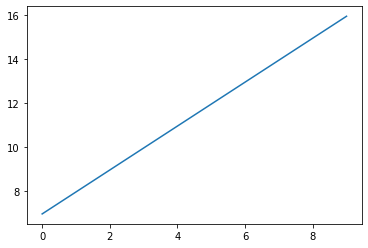

In [87]:
plt.plot(x0s, xs)
plt.show()

In [89]:
def get_jumped_distances_vx0(t0, tend, x0s, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy):
    values = []
    for vx0 in vx0s:
        values.append(get_jumped_distance(t0, tend, x0, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy))
    return values

In [90]:
vx0s = range(0,10)
xs = get_jumped_distances_vx0(t0, tend, x0s, vx0, y0, vy0, alphax, m, windx_dir, windx, alphay, windy_dir, windy)

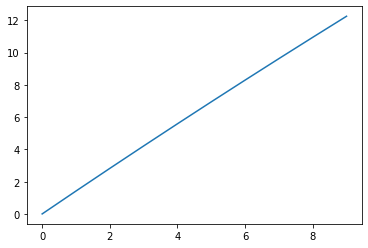

In [91]:
plt.plot(vx0s, xs)
plt.show()

In [5]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv')

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        id='year-slider',
        min=df['year'].min(),
        max=df['year'].max(),
        value=df['year'].min(),
        marks={str(year): str(year) for year in df['year'].unique()},
        step=None
    )
])


@app.callback(
    Output('graph-with-slider', 'figure'),
    Input('year-slider', 'value'))
def update_figure(selected_year):
    filtered_df = df[df.year == selected_year]

    fig = px.scatter(filtered_df, x="gdpPercap", y="lifeExp",
                     size="pop", color="continent", hover_name="country",
                     log_x=True, size_max=55)

    fig.update_layout(transition_duration=500)

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)


ImportError: Plotly express requires pandas to be installed.